### Edgar Moises Hernandez-Gonzalez
#### 16/04/20-20/04/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Escalogramas CWT (3D)
##### Concatenacion vertical
##### Resize proporcional de 352x62
##### Data Augmentation
##### 5 ejecuciones independientes

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import pywt
import cv2
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [ ]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [ ]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/Ventaneo-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/Ventaneo-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasVentaneo-A01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasVentaneo-A01E.csv", header=None)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6048, 11000)
(6048, 11000)
(6048, 1)
(6048, 1)


In [ ]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 6048
n_samples_test : 6048


In [ ]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [ ]:
#codificar etiquetas con valores de 0 a nClases-1
#le = LabelEncoder().fit(y_train)
#y_train = le.transform(y_train)
#y_test = le.transform(y_test)

In [ ]:
# las etiquetas en categorical para poder entrenar data augmentation
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [ ]:
#unir 22 canales
def unir_escalogramas_vertical_resize(data):
  escalas = np.arange(1,129)
  dim = (62, 352) #ancho, alto
  datos = np.zeros((6048,352,62))
  temporal = np.zeros((2816,500))
  for i in range(data.shape[0]): #6048 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*500:(j+1)*500]
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3') #escalograma CWT
      temporal[j*128:(j+1)*128, :] = abs(coef)
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
  return datos

In [ ]:
#llamar a escalogramas(data)
#primero x_train para no acabarse la RAM
x_train = unir_escalogramas_vertical_resize(x_train)

KeyboardInterrupt: ignored

In [ ]:
#llamar a escalogramas(data)
#despues x_test para no acabarse la RAM
x_test = unir_escalogramas_vertical_resize(x_test)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(6048, 352, 62)
(6048, 352, 62)


In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

61.44195678982832
55.95270140093569
0.0015741318929519072
0.0014695295012428222
3.7711482092387025
3.675984998574758


In [ ]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 62.0
x_test /= 62.0

In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.9909993
0.9024629
2.5389225e-05
2.3702089e-05
0.060824994
0.059290085


In [ ]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(6048, 352, 62, 1)
(6048, 352, 62, 1)


In [ ]:
datagen_train = ImageDataGenerator(width_shift_range=0.25)

In [ ]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(8, (3,3), activation='relu', input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3), activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3), activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
Epoch 1/400
 - 12s - loss: 1.3873 - accuracy: 0.2692 - val_loss: 1.3860 - val_accuracy: 0.2599
Epoch 2/400
 - 10s - loss: 1.3838 - accuracy: 0.2687 - val_loss: 1.3835 - val_accuracy: 0.2485
Epoch 3/400
 - 10s - loss: 1.3817 - accuracy: 0.2621 - val_loss: 1.3813 - val_accuracy: 0.2498
Epoch 4/400
 - 10s - loss: 1.3790 - accuracy: 0.2885 - val_loss: 1.3784 - val_accuracy: 0.2717
Epoch 5/400
 - 10s - loss: 1.3759 - accuracy: 0.2988 - val_loss: 1.3745 - val_accuracy: 0.2847
Epoch 6/400
 - 10s - loss: 1.3709 - accuracy: 0.2998 - val_loss: 1.3694 - val_accuracy: 0.2984
Epoch 7/400
 - 10s - loss: 1.3669 - accuracy: 0.3122 - val_loss: 1.3636 - val_accuracy: 0.3318
Epoch 8/400
 - 10s - loss: 1.3593 - accuracy: 0.3433 - val_loss: 1.3569 - val_accuracy: 0.3514
Epoch 9/400
 - 10s - loss: 1.3509 - accuracy: 0.3423 - val_loss: 1.3480 - val_accuracy: 0.3363
Epoch 10/400
 - 10s - loss: 1.3439 - accuracy: 0.3522 - val_loss: 1.3379 - val_accuracy: 0.3662
Epoch 11/400
 - 10s - loss: 1.3354 -

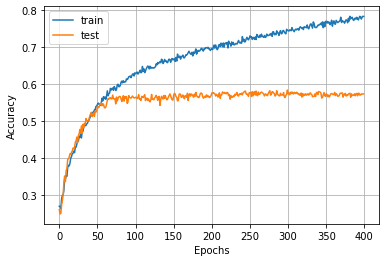

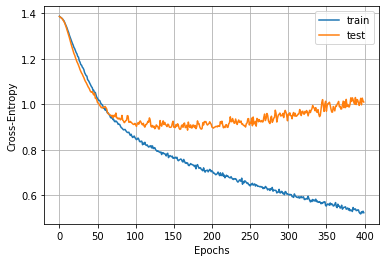

Iteration: 2
Epoch 1/400
 - 10s - loss: 1.3865 - accuracy: 0.2688 - val_loss: 1.3843 - val_accuracy: 0.2500
Epoch 2/400
 - 10s - loss: 1.3817 - accuracy: 0.2531 - val_loss: 1.3806 - val_accuracy: 0.2500
Epoch 3/400
 - 10s - loss: 1.3788 - accuracy: 0.2520 - val_loss: 1.3778 - val_accuracy: 0.2500
Epoch 4/400
 - 10s - loss: 1.3763 - accuracy: 0.2513 - val_loss: 1.3741 - val_accuracy: 0.2500
Epoch 5/400
 - 10s - loss: 1.3722 - accuracy: 0.2545 - val_loss: 1.3698 - val_accuracy: 0.2500
Epoch 6/400
 - 10s - loss: 1.3663 - accuracy: 0.2636 - val_loss: 1.3646 - val_accuracy: 0.2521
Epoch 7/400
 - 10s - loss: 1.3598 - accuracy: 0.2855 - val_loss: 1.3573 - val_accuracy: 0.2774
Epoch 8/400
 - 9s - loss: 1.3533 - accuracy: 0.3046 - val_loss: 1.3485 - val_accuracy: 0.3122
Epoch 9/400
 - 10s - loss: 1.3438 - accuracy: 0.3442 - val_loss: 1.3380 - val_accuracy: 0.3672
Epoch 10/400
 - 10s - loss: 1.3332 - accuracy: 0.3710 - val_loss: 1.3248 - val_accuracy: 0.3920
Epoch 11/400
 - 10s - loss: 1.3197 - 

In [ ]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  history = model.fit_generator(datagen_train.flow(x_train, y_train_categorical, batch_size=512),
                                steps_per_epoch=np.ceil(n_samples_train/512),
                                epochs=400,
                                validation_data=(x_test, y_test_categorical),
                                verbose=2)

  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [ ]:
model.summary()

In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))